This notebook is a personnal study of hyper parameters tuning with simple models and synthetic datasets.

Inspirations:
- https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_stats.html

In [1]:
import numpy as np
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
print("Setup Complete")

Setup Complete


In [2]:
rng = np.random.RandomState(0)
print("Prayer to RNGesus Sent")

Prayer to RNGesus Sent


In [3]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# Classification dataset

In [4]:
from sklearn.datasets import (
    make_blobs, make_moons, make_circles, make_classification,
    make_gaussian_quantiles
)

# for plotting in 2D space
n_features = 2
columns = ['x', 'y']

# moons
dataset = make_moons(
    n_samples=1000, random_state=rng,
    noise=0.3
)

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=5)

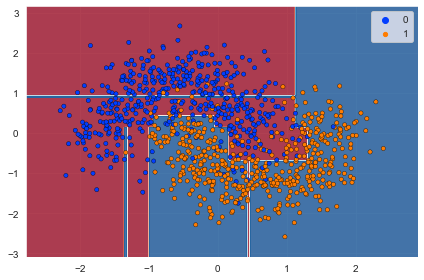

In [6]:
X, y = dataset

X = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.4, random_state=rng
)

clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)

h = .02  # step size in the mesh
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

fig, ax = plt.subplots()
cm = plt.cm.RdBu
ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
# sns.kdeplot(x=X[:, 0], y=X[:, 1], hue=y, shade=True, alpha=0.5)
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette='bright', ax=ax, size=1, edgecolor='k')

ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())

fig.tight_layout()
plt.show()

In [7]:
clf.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [46]:
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold

param_grid = [
    {'max_depth': [5, 10, 15], 'min_samples_leaf': [1, 2, 5, 10]}
]

cv = RepeatedStratifiedKFold(
    n_splits=10, n_repeats=10, random_state=0
)

search = GridSearchCV(
    estimator=clf, param_grid=param_grid,
    scoring='roc_auc', cv=cv,
    verbose=1,
    n_jobs=-1
)
search.fit(X, y)

Fitting 100 folds for each of 12 candidates, totalling 1200 fits


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=10, random_state=0),
             estimator=DecisionTreeClassifier(max_depth=5), n_jobs=-1,
             param_grid=[{'max_depth': [5, 10, 15],
                          'min_samples_leaf': [1, 2, 5, 10]}],
             scoring='roc_auc', verbose=1)

In [15]:
results_df = pd.DataFrame(search.cv_results_)
results_df = results_df.sort_values(by=['rank_test_score'])
results_df = (
    results_df
    .set_index(results_df["params"].apply(
        lambda x: "_".join(str(val) for val in x.values()))
    )
    .rename_axis('kernel')
)
results_df[
    ['params', 'rank_test_score', 'mean_test_score', 'std_test_score']
]

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
5_5,"{'max_depth': 5, 'min_samples_leaf': 5}",1,0.951724,0.021139
5_10,"{'max_depth': 5, 'min_samples_leaf': 10}",2,0.951690,0.021366
5_2,"{'max_depth': 5, 'min_samples_leaf': 2}",3,0.950110,0.021555
5_1,"{'max_depth': 5, 'min_samples_leaf': 1}",4,0.944990,0.023573
10_10,"{'max_depth': 10, 'min_samples_leaf': 10}",5,0.944394,0.022800
15_10,"{'max_depth': 15, 'min_samples_leaf': 10}",6,0.944280,0.022829
10_5,"{'max_depth': 10, 'min_samples_leaf': 5}",7,0.933754,0.024398
15_5,"{'max_depth': 15, 'min_samples_leaf': 5}",8,0.931492,0.024865
10_2,"{'max_depth': 10, 'min_samples_leaf': 2}",9,0.913830,0.025468


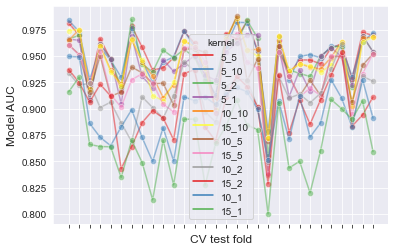

Correlation of models:
 kernel       5_5      5_10       5_2       5_1     10_10     15_10      10_5  \
kernel                                                                         
5_5     1.000000  0.955334  0.899132  0.833179  0.838054  0.844492  0.786594   
5_10    0.955334  1.000000  0.859528  0.818346  0.843064  0.857249  0.756853   
5_2     0.899132  0.859528  1.000000  0.932147  0.720226  0.716332  0.688820   
5_1     0.833179  0.818346  0.932147  1.000000  0.689203  0.693317  0.658407   
10_10   0.838054  0.843064  0.720226  0.689203  1.000000  0.983769  0.816233   
15_10   0.844492  0.857249  0.716332  0.693317  0.983769  1.000000  0.814737   
10_5    0.786594  0.756853  0.688820  0.658407  0.816233  0.814737  1.000000   
15_5    0.795867  0.758888  0.687465  0.651087  0.818495  0.820102  0.974393   
10_2    0.605394  0.585684  0.490014  0.498840  0.636550  0.617039  0.680796   
15_2    0.625547  0.614090  0.540244  0.553805  0.683023  0.661075  0.662427   
10_1    0.513637

In [16]:
# create df of model scores ordered by performance
model_scores = results_df.filter(regex=r'split\d*_test_score')

# plot 30 examples of dependency between cv fold and AUC scores
fig, ax = plt.subplots()
sns.lineplot(
    data=model_scores.transpose().iloc[:30],
    dashes=False, palette='Set1', marker='o', alpha=.5, ax=ax
)
ax.set_xlabel("CV test fold", size=12, labelpad=10)
ax.set_ylabel("Model AUC", size=12)
ax.tick_params(bottom=True, labelbottom=False)
plt.show()

# print correlation of AUC scores across folds
print(f"Correlation of models:\n {model_scores.transpose().corr()}")

In [25]:
def corrected_std(differences, n_train, n_test):
    """Corrects standard deviation using Nadeau and Bengio's approach.

    Parameters
    ----------
    differences : ndarray of shape (n_samples,)
        Vector containing the differences in the score metrics of two models.
    n_train : int
        Number of samples in the training set.
    n_test : int
        Number of samples in the testing set.

    Returns
    -------
    corrected_std : float
        Variance-corrected standard deviation of the set of differences.
    """
    # kr = k times r, r times repeated k-fold crossvalidation,
    # kr equals the number of times the model was evaluated
    kr = len(differences)
    corrected_var = (
        np.var(differences, ddof=1) * (1 / kr + n_test / n_train)
    )
    corrected_std = np.sqrt(corrected_var)
    return corrected_std


In [26]:
model_1_scores = model_scores.iloc[0].values  # scores of the best model
model_2_scores = model_scores.iloc[1].values  # scores of the second-best model

differences = model_1_scores - model_2_scores

n = differences.shape[0]  # number of test sets
df = n - 1
n_train = len(list(cv.split(X, y))[0][0])
n_test = len(list(cv.split(X, y))[0][1])

In [27]:
n_test

100

In [29]:
from scipy.stats import t

# initialize random variable
t_post = t(
    df, loc=np.mean(differences),
    scale=corrected_std(differences, n_train, n_test)
)

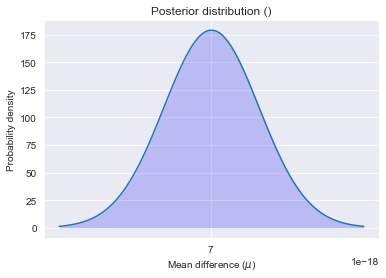

In [34]:
x = np.linspace(t_post.ppf(0.001), t_post.ppf(0.999), 100)

plt.plot(x, t_post.pdf(x))
plt.xticks(np.arange(-0.04, 0.06, 0.01))
plt.fill_between(x, t_post.pdf(x), 0, facecolor='blue', alpha=.2)
plt.ylabel("Probability density")
plt.xlabel(r"Mean difference ($\mu$)")
plt.title("Posterior distribution ()")

plt.show()

In [35]:
better_prob = 1 - t_post.cdf(0)

print(f"Probability of {model_scores.index[0]} being more accurate than "
      f"{model_scores.index[1]}: {better_prob:.3f}")
print(f"Probability of {model_scores.index[1]} being more accurate than "
      f"{model_scores.index[0]}: {1 - better_prob:.3f}")

Probability of 5_5 being more accurate than 5_10: 0.506
Probability of 5_10 being more accurate than 5_5: 0.494


In [37]:
rope_interval = [-0.01, 0.01]
rope_prob = t_post.cdf(rope_interval[1]) - t_post.cdf(rope_interval[0])

print(f"Probability of {model_scores.index[0]} and {model_scores.index[1]} "
      f"being practically equivalent: {rope_prob:.3f}")

Probability of 5_5 and 5_10 being practically equivalent: 1.000


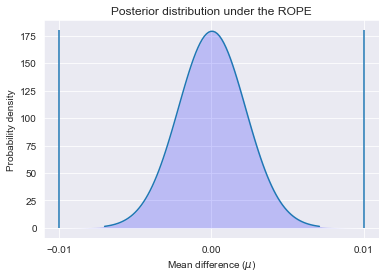

In [38]:
x_rope = np.linspace(rope_interval[0], rope_interval[1], 100)

plt.plot(x, t_post.pdf(x))
plt.xticks(np.arange(-0.04, 0.06, 0.01))
plt.vlines([-0.01, 0.01], ymin=0, ymax=(np.max(t_post.pdf(x)) + 1))
plt.fill_between(x_rope, t_post.pdf(x_rope), 0, facecolor='blue', alpha=.2)
plt.ylabel("Probability density")
plt.xlabel(r"Mean difference ($\mu$)")
plt.title("Posterior distribution under the ROPE")
plt.show()

In [39]:
cred_intervals = []
intervals = [0.5, 0.75, 0.95]

for interval in intervals:
    cred_interval = list(t_post.interval(interval))
    cred_intervals.append([interval, cred_interval[0], cred_interval[1]])

cred_int_df = pd.DataFrame(
    cred_intervals,
    columns=['interval', 'lower value', 'upper value']
).set_index('interval')
cred_int_df

,lower value,upper value
interval,,
0.50,-0.001471,0.001539
0.75,-0.002538,0.002606
0.95,-0.004377,0.004445


In [42]:
from itertools import combinations

pairwise_bayesian = []

for model_i, model_k in combinations(range(len(model_scores)), 2):
    model_i_scores = model_scores.iloc[model_i].values
    model_k_scores = model_scores.iloc[model_k].values
    differences = model_i_scores - model_k_scores
    t_post = t(
        df, loc=np.mean(differences),
        scale=corrected_std(differences, n_train, n_test)
    )
    worse_prob = t_post.cdf(rope_interval[0])
    better_prob = 1 - t_post.cdf(rope_interval[1])
    rope_prob = t_post.cdf(rope_interval[1]) - t_post.cdf(rope_interval[0])

    pairwise_bayesian.append([worse_prob, better_prob, rope_prob])

pairwise_bayesian_df = (pd.DataFrame(
    pairwise_bayesian,
    columns=['worse_prob', 'better_prob', 'rope_prob']
).round(3))

pairwise_bayesian_df

,worse_prob,better_prob,rope_prob
0,0.000,0.000,1.000
1,0.000,0.007,0.993
2,0.000,0.239,0.761
3,0.000,0.273,0.727
4,0.000,0.278,0.722
...,...,...,...
61,0.000,0.827,0.173
62,0.000,1.000,0.000
63,0.059,0.181,0.761
64,0.000,0.994,0.006


In [47]:
from sklearn.model_selection import HalvingRandomSearchCV

ImportError: cannot import name 'HalvingRandomSearchCV' from 'sklearn.model_selection' (E:\Projects\Kaggle-Projects\env\lib\site-packages\sklearn\model_selection\__init__.py)